# Dependency code

In [1]:
import imp
import os
import sys
import numpy as np
import glob
import cmdbench

fp, pathname, description = imp.find_module('benchmark', ['../lib'])
benchmark = imp.load_module('benchmark', fp, pathname, description)

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

# Software versions

COBS will have to be built directly from source <https://github.com/bingmann/cobs>. Version used is commit `1915fc061bbe47946116b4a051ed7b4e3f3eca15`. I have included the binary in the directory `../lib/bin`.

In [2]:
cobs_bin = '../lib/bin/cobs'
!ls ../lib/bin
!{cobs_bin}

cobs  cobs_1915fc061bbe47946116b4a051ed7b4e3f3eca15  STing
(Co)mpact (B)it-Sliced (S)ignature Index for Genome Search

Usage: ../lib/bin/cobs <subtool> ...

Available subtools: 
  doc-list                   read a list of documents and print the list
  doc-dump                   read a list of documents and dump their contents
  classic-construct          constructs a classic index from the documents in <in_dir>
  classic-construct-random   constructs a classic index with random content
  compact-construct          creates the folders used for further construction
  compact-construct-combine  combines the classic indices in <in_dir> to form a compact index
  query                      query an index
  print-parameters           calculates index parameters
  print-kmers                print all canonical kmers from <query>
  benchmark-fpr              run benchmark and false positive measurement
  generate-queries           select queries randomly from documents

See https://panthema.ne

# Benchmarking

## Input data and constants

In [3]:
input_dir = '../data/input-files/reads'

input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
input_samples.sort()
print(input_samples)

nproc=32
kmer=31
hashes=3

sample_sizes = [1,10,20,30,40,50,60,70,80]

benchmark.create_folder_if_doesnt_exist("cobs-data")
benchmark.create_folder_if_doesnt_exist("cobs-data/samples")

['2014C-3598', '2014C-3599', '2014C-3600', '2014C-3655', '2014C-3656', '2014C-3840', '2014C-3850', '2014C-3857', '2014C-3907', '2014D-0067', '2014D-0068', '2014D-0070', '2014D-0189', 'CFSAN002349', 'CFSAN023463', 'CFSAN023464', 'CFSAN023465', 'CFSAN023466', 'CFSAN023467', 'CFSAN023468', 'CFSAN023469', 'CFSAN023470', 'CFSAN023471', 'D5663', 'D7316', 'D7319', 'D7320', 'D7321', 'D7322', 'D7323', 'D7324', 'D7327', 'D7328', 'D7329', 'D7330', 'D7331', 'D7333', 'D7334', 'MOD1_LS1000', 'MOD1_LS1003', 'MOD1_LS1004', 'MOD1_LS1005', 'MOD1_LS1006', 'MOD1_LS1008', 'MOD1_LS1009', 'MOD1_LS1010', 'MOD1_LS1011', 'MOD1_LS982', 'MOD1_LS985', 'MOD1_LS989', 'MOD1_LS994', 'MOD1_LS995', 'MOD1_LS996', 'MOD1_LS997', 'MOD1_LS998', 'PNUSA000194', 'PNUSA000195', 'PNUSA000196', 'PNUSAL000730', 'PNUSAL000870', 'PNUSAL000957', 'PNUSAL001024', 'SIM_CFSAN000189', 'SIM_CFSAN000191', 'SIM_CFSAN000211', 'SIM_CFSAN000212', 'SIM_CFSAN000228', 'SIM_CFSAN000661', 'SIM_CFSAN000669', 'SIM_CFSAN000700', 'SIM_CFSAN000752', 'SIM_

## Benchmark functions

In [4]:
def sampling_func(sample_size):
    # Copy files we want to be part of the sample
    # from inputs to cobs-data/samples/ and return their path
    samples = input_samples[:sample_size]
    samples_out = []
    for sample in samples:
        infile1, infile2 = os.path.abspath(f"{input_dir}/{sample}_1.fastq.gz"), os.path.abspath(f"{input_dir}/{sample}_2.fastq.gz")
        outfile1, outfile2 = f"cobs-data/samples/{sample}_1.fastq.gz", f"cobs-data/samples/{sample}_2.fastq.gz"
        os.symlink(infile1, outfile1)
        os.symlink(infile2, outfile2)
    return ["cobs-data/samples/"]

def reset_func():
    benchmark.clean_if_exists("cobs-data/samples/")
    benchmark.clean_if_exists("cobs-data/example.cobs_compact")
    benchmark.clean_if_exists("cobs-data/example.cobs_compact.tmp")

build_command = {
    "command": f"{cobs_bin} compact-construct -k {kmer} --threads {nproc} --num-hashes {hashes} cobs-data/samples/ cobs-data/example.cobs_compact",
}

query_repeat_count = 2
query_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"

query_command = {
    "command": f"{cobs_bin} query -i cobs-data/example.cobs_compact %",
    "parallel_argfiles": [query_sequence] * query_repeat_count,
    "parallel_args": f"-j {nproc} -I%"
}

## Benchmark

In [5]:
multibench_results, debug_str = benchmark.multibench.multi_cmdbench({
        "index": [build_command],
        "query": [query_command]
    },
    reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark.benchmark_list_to_results, active_output_print = True
)

>>>>>>>>>>>>>
../lib/bin/cobs compact-construct -k 31 --threads 32 --num-hashes 3 cobs-data/samples/ cobs-data/example.cobs_compact

STDOUT: --- document list (2 entries) ---
document[0] size 81844092 31-mers 108406183 : cobs-data/samples/2014C-3598_1.fastq.gz : 2014C-3598_1
document[1] size 99885612 31-mers 108404444 : cobs-data/samples/2014C-3598_2.fastq.gz : 2014C-3598_2
--- end of document list (2 entries) ---
documents: 2
minimum 31-mers: 108404444
maximum 31-mers: 108406183
average 31-mers: 108405313
total 31-mers: 216810627

-------------
STDERR: Parameters:
  input                      (string)            "cobs-data/samples/"
  out_file                   (string)            "cobs-data/example.cobs_compact"
Options:
  -C, --clobber              (bool)              false
      --continue             (bool)              false
  -f, --false-positive-rate  (double)            0.3
      --file-type            (string)            "any"
      --keep-temporary       (bool)              

# Save and reload results

In [6]:
save_path = "cobs-results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

benchmark.multibench.save_multibench_results(multibench_results, samples_per_sample_size, save_path)
multibench_results, samples_per_sample_size = benchmark.multibench.read_multibench_results(save_path)
print(samples_per_sample_size)

[['2014C-3598'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067,', '2014D-0068,', '2014D-0070,', '2014D-0189,', 'CFSAN002349,', 'CFSAN023463,', 'CFSAN023464,', 'CFSAN023465,', 'CFSAN023466,', 'CFSAN023467,', 'CFSAN023468'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067,', '2014D-0068,', '2014D-0070,', '2014D-0189,', 'CFSAN002349,', 'CFSAN023463,', 'CFSAN023464,', 'CFSAN023465,', 'CFSAN023466,', 'CFSAN023467,', 'CFSAN023468,', 'CFSAN023469,', 'CFSAN023470,', 'CFSAN023471,', 'D5663,', 'D7316,', 'D7319,', 'D7320,', 'D7321,', 'D7322,', 'D7323'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-

# Plot

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'runtime': 79.84, 'memory': 299175936.0, 'disk_read': 657324373.0, 'disk_write': 2644193793.0}, {'runtime': 513.91, 'memory': 2525884416.0, 'disk_read': 10390840216.0, 'disk_write': 11761063796.0}, {'runtime': 594.95, 'memory': 4206497792.0, 'disk_read': 17907334791.0, 'disk_write': 15121415120.0}, {'runtime': 1015.28, 'memory': 9550729216.0, 'disk_read': 37668579979.0, 'disk_write': 28634197707.0}, {'runtime': 2177.62, 'memory': 7320731648.0, 'disk_read': 45774518641.0, 'disk_write': 33867563053.0}, {'runtime': 1886.37, 'memory': 5976080384.0, 'disk_read': 56528274694.0, 'disk_write': 36326774714.0}, {'runtime': 1938.99, 'memory': 8362319872.0, 'disk_read': 66392489863.0, 'disk_write': 39342085258.0}, {'runtime': 1681.84, 'memory': 10826829824.0, 'disk_read': 68412436477.0, 'disk_write': 44383179882.0}, {'runtime': 1829.74, 'memory': 11524444160.0, 'disk_read': 76159239492.0, 'disk_write': 47259808556.0}]


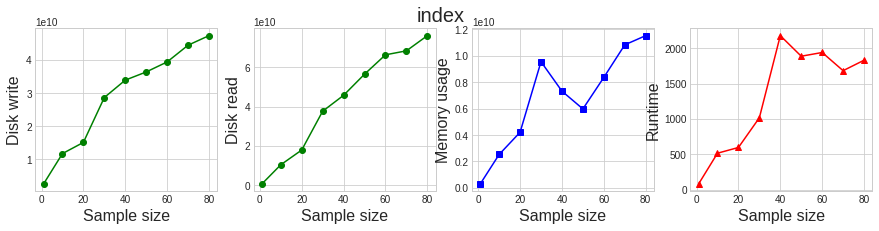

In [8]:
# Indexing Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "index")

[{'runtime': 0.16, 'memory': 22462464.0, 'disk_read': 970642.0, 'disk_write': 238229.0}, {'runtime': 0.13, 'memory': 19017728.0, 'disk_read': 971155.0, 'disk_write': 222859.0}, {'runtime': 0.14, 'memory': 18903040.0, 'disk_read': 971158.0, 'disk_write': 222867.0}, {'runtime': 0.47, 'memory': 23658496.0, 'disk_read': 972015.0, 'disk_write': 313032.0}, {'runtime': 0.16, 'memory': 33284096.0, 'disk_read': 971182.0, 'disk_write': 231100.0}, {'runtime': 0.57, 'memory': 45379584.0, 'disk_read': 968692.0, 'disk_write': 280258.0}, {'runtime': 0.97, 'memory': 52322304.0, 'disk_read': 971183.0, 'disk_write': 386751.0}, {'runtime': 1.02, 'memory': 32653312.0, 'disk_read': 972022.0, 'disk_write': 231096.0}, {'runtime': 1.34, 'memory': 50040832.0, 'disk_read': 971187.0, 'disk_write': 534229.0}]


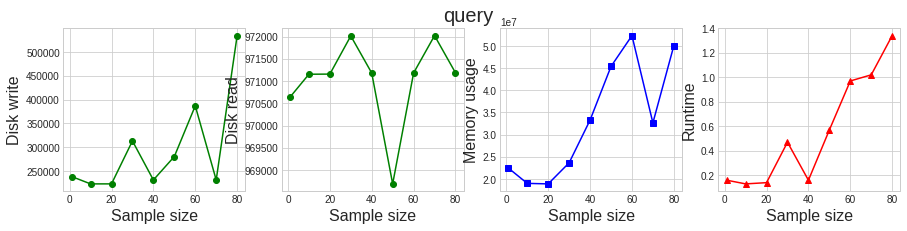

In [9]:
# Querying Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "query")